In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sp

In [2]:
path = "./data/data.csv"
df = pd.read_csv(path)

In [3]:
N_SUBJECTS = 10
N_CONDITIONS = 3
N_REPS = 10
N_SENSORS = 6
N_TRIALS = N_SUBJECTS * N_CONDITIONS * N_REPS

# Preprocessing

In [4]:
trials = ["subject", "condition", "replication"]
index_columns = trials + ["time"]
df = df.set_index(index_columns)

matrix = pd.DataFrame()
joint_map = {1: "ankle", 2: "knee", 3: "hip"}
leg_map = {1: "left", 2: "right"}

for leg_key, leg_val in leg_map.items():
    for joint_key, joint_val in joint_map.items():
        matrix[f"{leg_val}_{joint_val}"] = df[(df.leg == leg_key) & (df.joint == joint_key)].angle

rs = matrix.reset_index()
series = pd.DataFrame((rs.subject - 1) * N_REPS * N_CONDITIONS + (rs.condition - 1) * N_REPS + rs.replication)
matrix["trial"] = series.set_index(matrix.index)




In [39]:
matrix

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     0       4.682881   3.693683  16.607868     5.015829    2.244425   
      1       5.073127   4.258876  16.851029     5.291201    3.381678   
      2       5.229774   5.346945  17.170098     5.410528    4.925566   
      3       5.083273   6.769831  17.504693     5.270628    6.623978   
      4       4.652399   8.351716  17.806602     4.814143    8.268602   
...                ...        ...        ...          ...         ...   
300   96      5.469052   0.964147  25.046914    -4.136161    2.616228   
      97      5.994900  -1.377103  24.753520    -4.050542    0.721412   
      98      6.625519  -2.884798  24.636438    -3.933841   -0.629712   
      99      7.293149  -3.532651  24.695275    -3.837398   -1.438054   
      100     7.877814  -3.379236  24.901665    -3.823557   -1.747282   

            right_hip  
trial time             
1     0     18.948290  
      1     19.265300  
      2     19.600469  
      3     19.871755  
      4     20.016564  
...               ...  
300   96    29.778412  
      97    29.247559  
      98    28.796951  
      99    28.432936  
      100   28.136438  

[30300 rows x 6 columns]

In [40]:
matrix2

,trial,time,variable,value
0,1,0,left_ankle,4.682881
1,1,1,left_ankle,5.073127
2,1,2,left_ankle,5.229774
3,1,3,left_ankle,5.083273
4,1,4,left_ankle,4.652399
...,...,...,...,...
181795,300,96,right_hip,29.778412
181796,300,97,right_hip,29.247559
181797,300,98,right_hip,28.796951
181798,300,99,right_hip,28.432936


In [5]:
matrix.head(2)

left_ankle  left_knee   left_hip  \
subject condition replication time                                     
1       1         1           0       4.682881   3.693683  16.607868   
                              1       5.073127   4.258876  16.851029   

                                    right_ankle  right_knee  right_hip  trial  
subject condition replication time                                             
1       1         1           0        5.015829    2.244425   18.94829      1  
                              1        5.291201    3.381678   19.26530      1

In [6]:
target = pd.Series(range(N_TRIALS), index=range(1, N_TRIALS + 1))
target = 1 + ((target // 10) % 3)
target.name = "condition"

matrix = matrix.reset_index().drop(trials, axis=1).set_index(["trial", "time"])

In [7]:
target2 = pd.Series(range(N_TRIALS * N_SENSORS), index=range(1, N_TRIALS * N_SENSORS + 1))
target2 = 1 + ((target2 // 60) % 3)
target2.name = "condition"

matrix2 = matrix.reset_index().melt(id_vars=["trial", "time"])

In [303]:
means = matrix.groupby("trial").mean()
means.columns=[f"{col}_mean" for col in matrix.columns]
stdevs = matrix.groupby("trial").std()
stdevs.columns=[f"{col}_stdev" for col in matrix.columns]
other_features = pd.DataFrame()

means = means.T.iloc[0:6].T

In [365]:
ankles = matrix[["left_ankle", "right_ankle"]]
knees = matrix[["left_knee", "right_knee"]]
hips = matrix[["left_hip", "right_hip"]]

left_ankle  left_knee   left_hip  right_ankle  right_knee  \
trial time                                                              
1     51     13.280866   5.573957 -12.708399    13.547248    8.104331   
      52     13.358667   5.892645 -13.323654    13.584862    8.716051   
      53     13.369976   6.331077 -13.915811    13.531314    9.455649   
      54     13.295140   6.888184 -14.477692    13.364414   10.358133   
      55     13.126522   7.580026 -14.989757    13.073427   11.455962   
...                ...        ...        ...          ...         ...   
300   96      5.469052   0.964147  25.046914    -4.136161    2.616228   
      97      5.994900  -1.377103  24.753520    -4.050542    0.721412   
      98      6.625519  -2.884798  24.636438    -3.933841   -0.629712   
      99      7.293149  -3.532651  24.695275    -3.837398   -1.438054   
      100     7.877814  -3.379236  24.901665    -3.823557   -1.747282   

            right_hip  
trial time             
1     51   -12.565649  
      52   -12.888644  
      53   -13.169307  
      54   -13.387933  
      55   -13.519031  
...               ...  
300   96    29.778412  
      97    29.247559  
      98    28.796951  
      99    28.432936  
      100   28.136438  

[15000 rows x 6 columns]

In [480]:
corrs = pd.DataFrame()
covs = pd.DataFrame()

for body_part in ["ankle", "knee"]:

    second_half = matrix[matrix.index.get_level_values(1) > 50]
    body_parts = second_half[[f"left_{body_part}", f"right_{body_part}"]]
    corrs[body_part] = body_parts.groupby(["trial"]).corr(method="pearson").groupby("trial")[f"right_{body_part}"].first()
    covs[body_part] = body_parts.groupby(["trial"]).cov().groupby("trial")[f"right_{body_part}"].first()
# ankle_corrs = ankles.groupby(["trial"]).corr(method="pearson").groupby("trial").right_ankle.first()
# knee_corrs = knees.groupby(["trial"]).corr(method="pearson").groupby("trial").right_ankle.first()
# ankle_corrs = ankles.groupby(["trial"]).corr(method="pearson").groupby("trial").right_ankle.first()


In [481]:
# two sets of features:
# base: mean of some of the sensors
# correlation model
# fft model

# extension: only look at the second half

In [482]:
grouped = matrix2.groupby(["trial", "variable"])
means2 = grouped.mean().drop("time", axis=1)
means2.name = "mean"
stdevs2 = grouped.std().drop("time", axis=1)
low_q = grouped.quantile(0.25).drop("time", axis=1)
high_q = grouped.quantile(0.75).drop("time", axis=1)

In [632]:
features = pd.concat([covs], axis=1)

features2 = pd.concat([means2, stdevs2, low_q, high_q], axis=1)
features2.columns = ["mean", "std", "low", "high"]

In [633]:
from scipy.fft import fft, ifft, fftfreq


# CV fns

In [634]:
def cross_validation_splits(train_validation_data, targets, number_of_folds):
    
    # Convert input data to numpy array if it's not already
    train_validation_data = np.array(train_validation_data)
    targets = np.array(targets)

    # Check if input_data and targets have the same number of rows
    if train_validation_data.shape[0] != targets.shape[0]:
        print("Input Data and Targets do not have the same number of entries.")
        print(f"input_data.shape = {train_validation_data.shape}")

    # Randomly assign each data point to a fold
    fold_assignments = np.random.randint(0, number_of_folds, size=targets.size)
    print(fold_assignments)

    # Saving the different splits in a list
    folds = []

    for f in range(number_of_folds):
        train_filter = (fold_assignments != f)
        valid_filter = ~train_filter

        train_inputs = train_validation_data[train_filter, :]
        train_targets = targets[train_filter]
        valid_inputs = train_validation_data[valid_filter, :]
        valid_targets = targets[valid_filter]

        fold = {
            "train_inputs": train_inputs,
            "train_targets": train_targets,
            "valid_inputs": valid_inputs,
            "valid_targets": valid_targets
        }
        folds.append(fold)

        print(f"For fold {f}")
        print(f"\ttrain_inputs.shape = {train_inputs.shape}")
        print(f"\ttrain_targets.shape = {train_targets.shape}")
        print(f"\tvalid_inputs.shape = {valid_inputs.shape}")
        print(f"\tvalid_targets.shape = {valid_targets.shape}")

    return folds

In [635]:
def cross_validate(
    X_train,
    y_train, 
    folds, 
    model,
    metric
    ):

    # logic of CV
    n = len(X_train)
    n_per_fold = n // folds
    metric_values = np.zeros(folds)

    for i in range(folds):
        validation_index = range(i * n_per_fold, (i+1) * n_per_fold)
        X_train_fold = X_train[~X_train.index.isin(validation_index)]
        y_train_fold = y_train[~y_train.index.isin(validation_index)]
        X_test_fold = X_train[X_train.index.isin(validation_index)]
        y_test_fold = y_train[y_train.index.isin(validation_index)]

        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_test_fold)
        metric_values[i] = (metric(y_test_fold, y_pred_fold))

    return metric_values

# Testing Model

In [636]:
# from functions.cross_validation import *

In [637]:
from sklearn import linear_model, ensemble
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [638]:
features

,ankle,knee
trial,,
1,25.358073,427.227958
2,27.345188,454.392643
3,34.354737,464.989680
4,29.061860,488.074552
5,28.686415,471.207712
...,...,...
296,6.308630,360.513534
297,8.593286,401.690949
298,14.082356,430.243623


In [639]:
TRAIN_SUBJECTS = 8
TRAIN_TRIALS = N_TRIALS * TRAIN_SUBJECTS / N_SUBJECTS

features_used = features
target_used = target

X = features_used.copy()
y = target_used.copy()

X_split = TRAIN_TRIALS
y_split = (X_split)

X_train = X.loc[:X_split]
y_train = y.loc[:y_split]
X_test = X.loc[X_split+1:]
y_test = y.loc[y_split +1:]

In [640]:
# cross_validate(X_train, y_train, 10, model=linear_model.LogisticRegression(), metric=accuracy_score)

In [641]:
# here we will use cross validation on X_train

In [642]:
X_test.shape

(60, 2)

In [643]:
y_test.shape

(60,)

In [644]:
# we can change this, need to have reasoning for the model
model = linear_model.LogisticRegression(max_iter=1000, multi_class="multinomial") 
# model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

<Axes: >

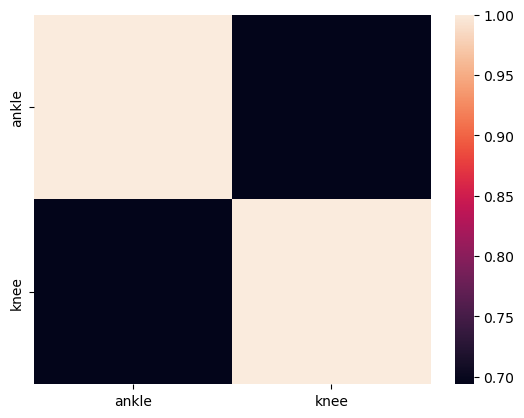

In [645]:
sns.heatmap(features.corr())

In [646]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)

for f in [confusion_matrix, accuracy_score]:
    print(str(f).split()[1])
    print(f(y_test, y_pred))

# wants clear divisions between classes - would work
print(log_loss(y_test, y_probs, eps=0.2))

# good scores - so look at the errors!

confusion_matrix
[[20  0  0]
 [ 0 20  0]
 [ 1  0 19]]
accuracy_score
0.9833333333333333
0.42385305449529065


<Axes: >

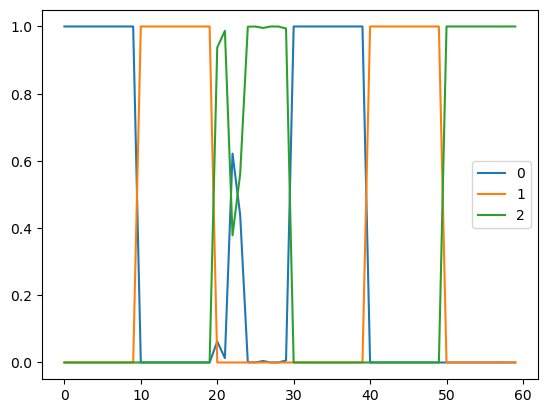

In [647]:
pd.DataFrame(y_probs).plot()

In [546]:
results = pd.concat([pd.Series(y_test).reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=False).sort_values(by="condition")
results.columns =["true", "pred"]

In [83]:
# ten subjects
# ten replications
# three conditions

# 6 measurements for each one (two legs, three joints)
# time series are 101 points long
# so the data is actually (300 x 101 x 6), so we should represent it as such.

# train-test split: 
# 7 subjects for train: should do leave-one-out validation (as in 1 subject each time)
# 3 subjects for test: leave three subjects for test